# Identifying Pneumonia by Chest X-Ray Images with Deep Learning

### Name: Heng Wang           /        Jiahao Zhao
### ID      : 001822598             /        001839375

<h1><font color = blue>What is our idea</h1>

Imagine how efficient it would be to diagnose pneumonia only by analyzing few chest X-Ray images on computers, it would be much more faster and accuracy than viewing by a doctor. It would not only improve the efficiency of identifying pneumonia, but also save more time and effort of professionals. <br><br>
Pneumonia is a very common disease. It can be either: 1) Bacterial pneumonia 2) Viral Pneumonia 3) Mycoplasma pneumonia and 4) Fungal pneumonia. This dataset consists pneumonia samples belonging to the first two classes. The dataset consists of only very few samples and that too unbalanced. The aim of this kernel is to develop a robust deep learning model from scratch on this limited amount of data. 

## Highlights
* Developed a Depthwise Separable Convolution Neural Network using transfer learning from Imagenet
* Classifying images for normal,  bacterial and viral and  pneumonia
* Augmenting is a powerful technique to deal with the imbalanced dataset  
* Building deep learning models

<div class="alert alert-block alert-success"><h2>Running Tensorflow with GPU</h2>
<h3> Supported devices  </h3> <br>
On a typical system, there are multiple computing devices. In TensorFlow, the supported device types are CPU and GPU. They are represented as strings. For example:

* "/cpu:0": The CPU of your machine.
* "/device:GPU:0": The GPU of your machine, if you have one.
* "/device:GPU:1": The second GPU of your machine, etc.<br>
To using gpu and get tutorials, pelase visit their  _[OFFICIAL SITE](https://www.tensorflow.org/guide/using_gpu)_<br><br>
 
__GPUs__ are so well-suited to deep learning because the type of calculations they were designed to process happens to be the same as those encountered in deep learning. Images, videos, and other graphics are represented as matrices, so that when you perform any operation, such as a zoom in effect or a camera rotation, all you are doing is applying some mathematical transformation to a matrix. In practice, this means that GPUs, compared to central processing units (CPUs), are more specialized at performing matrix operations and several other types of advanced mathematical transformations. This makes deep learning algorithms run several times faster on a GPU compared to a CPU. Learning times can often be reduced from days to mere hours. </div>

<div class="alert alert-block alert-info"> Before running the code, please install "tensorflow", "tensorflow-gpu" module through pip <br>
You can simple do it by typping "pip install tensorflow", "pip install tensorflow-gpu" in the Anaconda Prompt</div>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline
import tensorflow as tf
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
print(os.listdir("chest_xray"))

['.DS_Store', 'test', 'train', 'val']


## Reproducibility is a great concern when doing deep learning. 

In [3]:
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(111)

# Define a tensorflow session with above session configs
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

## The dataset is divided into three sets: 1) train set 2) validation set and 3) test set.

In [4]:
# Define path to the data directory
data_dir = Path('chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

## Training data set
### Each of the above directory contains three sub-directories:

* NORMAL: These are the samples that describe the normal (no pneumonia) case.
* BAC-PNEUMONIA: This directory contains those samples that are the bacteria pneumonia cases.
* VIR-PNEUMONIA : This directory contains those samples that are the virus pneumonia cases.


In [5]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
# pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
bacteria_cases = pneumonia_cases_dir.glob('*_bacteria_*.jpeg')
virus_cases = pneumonia_cases_dir.glob('*_virus_*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the bacteria cases. The label for these cases will be 1
for img in bacteria_cases:
    train_data.append((img, 1))
# Go through all the virus cases. The label for these cases will be 2
for img in virus_cases:
    train_data.append((img, 2))
# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,chest_xray\train\NORMAL\NORMAL2-IM-0454-0001.jpeg,0
1,chest_xray\train\NORMAL\NORMAL2-IM-1252-0001.jpeg,0
2,chest_xray\train\PNEUMONIA\person1096_bacteria...,1
3,chest_xray\train\PNEUMONIA\person441_bacteria_...,1
4,chest_xray\train\PNEUMONIA\person1634_bacteria...,1


# Calculate samples for each class are there in the dataset

1    2530
2    1345
0    1341
Name: label, dtype: int64


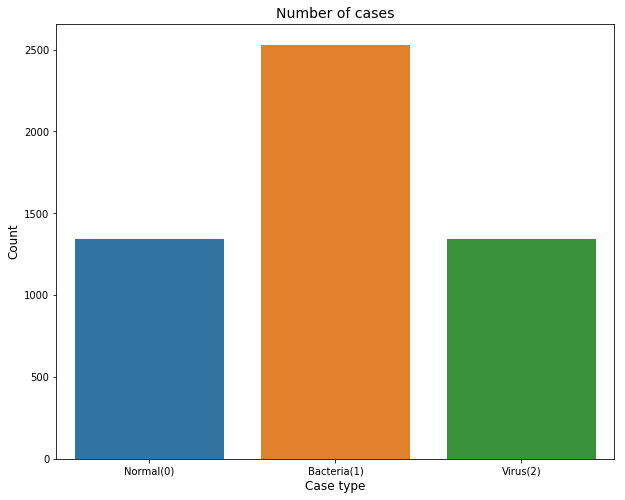

In [6]:
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Bacteria(1)', 'Virus(2)'])
plt.show()

<div class="alert alert-block alert-info">You can see the data is highly imbalanced. We have almost with two bacteria pneumonia cases here as compared to other cases. Although this situation is very normal when it comes to medical data.</div>

### Let's look at how a normal case is different from that of a pneumonia case. We will look at somes samples from our training data itself.

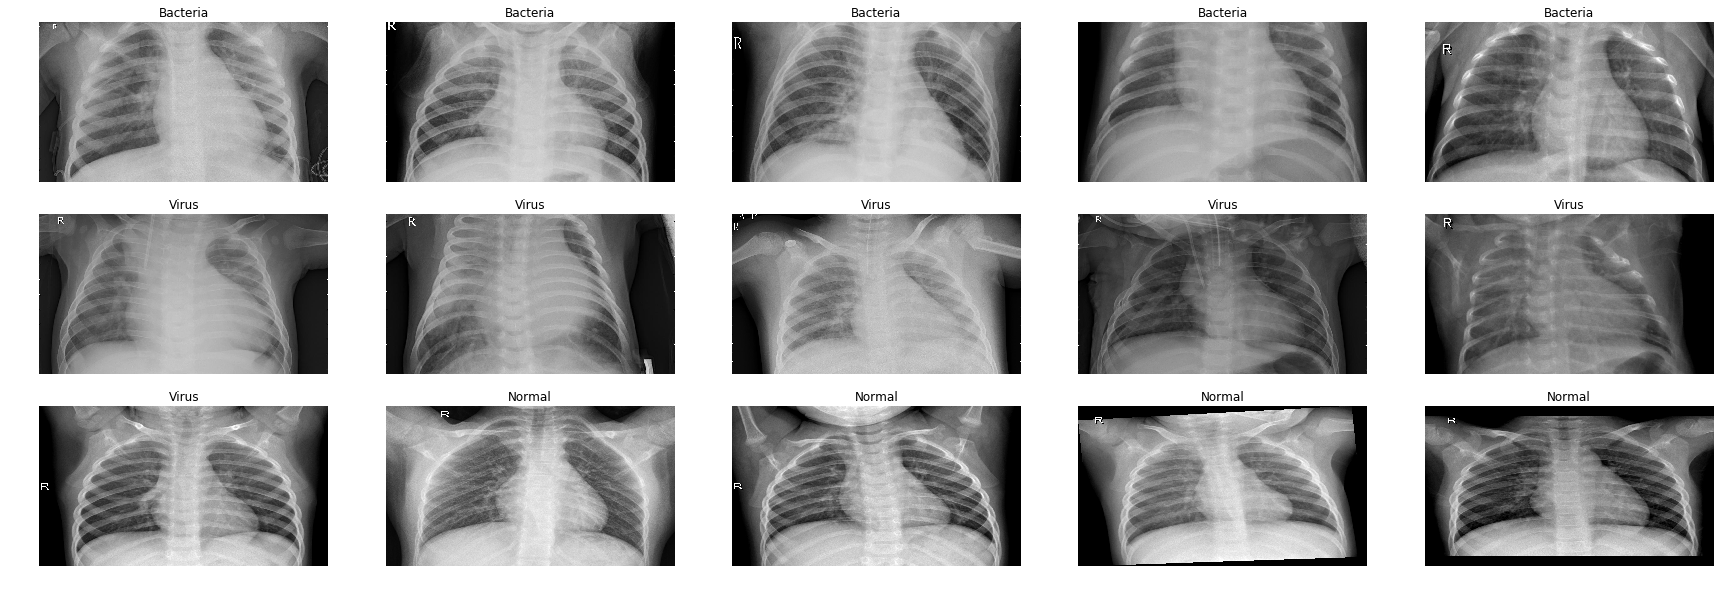

In [7]:
# Get few samples for both the classes
virus_samples = (train_data[train_data['label']==2]['image'].iloc[:5]).tolist()
bacteria_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = virus_samples + bacteria_samples + normal_samples
del virus_samples, bacteria_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(3,5, figsize=(30,10))
for i in range(15):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Bacteria")
    elif i>10:
        ax[i//5, i%5].set_title("Normal")
    else:
        ax[i//5, i%5].set_title("Virus")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

<div class="alert alert-block alert-info">There are some cases where you won't be able to differentiate between a normal case and a pneumonia case with the naked eye. If we can build a robust classifier, it would be a great assist to the doctor too.</div>

## Preparing validation data
We will be defining a generator for the training dataset later in the notebook but as the validation data is small, so I can read the images and can load the data without the need of a generator. This is exactly what the code block given below is doing.

In [8]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
# pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
bacteria_cases = pneumonia_cases_dir.glob('*_bacteria_*.jpeg')
virus_cases = pneumonia_cases_dir.glob('*_virus_*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=3)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Bac-Pneumonia cases        
for img in bacteria_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=3)
    valid_data.append(img)
    valid_labels.append(label)
    
# Vir-Pneumonia cases        
for img in virus_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(2, num_classes=3)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (16, 224, 224, 3)
Total number of labels: (16, 3)


## AuguData Augmentation

Data augmentation is a powerful technique which helps in almost every case for improving the robustness of a model. But augmentation can be much more helpful where the dataset is imbalanced. You can generate different samples of over sampled class in order to try to balance the overall distribution.

In [9]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [10]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,3), dtype=np.float32) #2->3

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=3)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-1:
                aug_img1 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                count +=1
                        
            elif label==2 and count < batch_size-1:
                aug_img1 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                count +=1
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

# Building deep learning model

* __Choose a simple architecture.__<br><br>
* __Initialize the first few layers from a network that is pretrained on imagenet.__<br>
This is because first few layers capture general details like color blobs, patches, edges, etc. Instead of randomly initialized weights for these layers, it would be much better if you fine tune them.We will initialize the weights of first two convolutions with VGG16 weights.<br><br>

* __Choose layers that introduce a lesser number of parameters.__ <br>
For example, Depthwise SeparableConv is a good replacement for Conv layer. It introduces lesser number of parameters as compared to normal convolution and as different filters are applied to each channel, it captures more information.<br>
$$Compare to Conv2D: 3*3*64*64 = 36,864$$
$$SeparableConv2D: 64*3*3+64*64 = 4672$$

* __Use batch norm with convolutions.__<br>
We normalize the input layer by adjusting and scaling the activations. For example, when we have features from 0 to 1 and some from 1 to 1000, we should normalize them to speed up learning. If the input layer is benefiting from it, why not do the same thing also for the values in the hidden layers, that are changing all the time, and get 10 times or more improvement in the training speed.<br><br>

* __Add dense layers with reasonable amount of neurons.__<br>
Train with a higher learning rate and experiment with the number of neurons in the dense layers. Do it for the depth of your network too.<br><br>
* __Start training your network with a lower learning rate along with decay.__

In [11]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img) #64 layers3*3--kernel，convolute
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1_2')(x) 
    x = MaxPooling2D((2,2), name='pool1')(x) # compress pictures
    
    x = SeparableConv2D(64, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(64, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(256, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(3, activation='softmax', name='fc3')(x) #2
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [12]:
model =  build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 32)      896       
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 32)      9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 32)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 64)      2400      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 64)      4736      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 64)        0         
__________

<div class="alert alert-block alert-success">
We will initialize the weights of first two convolutions with imagenet weights   </div>

In [13]:
# Open the VGG16 weight file
f = h5py.File('vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 32)      896       
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 32)      9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 32)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 64)      2400      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 64)      4736      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 64)        0         
__________

In [14]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(lr=0.0001, decay=1e-5) #lr=learning rate, decay: learning rate decay rate, adam learning function
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [15]:
train_data.shape

(5216, 2)

In [16]:
valid_data.shape

(16, 224, 224, 3)

In [17]:
batch_size = 20 #Bigger, more accurate
nb_epochs = 10

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 260 and 16


In [18]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

In [36]:
# Fit the model
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(valid_data, valid_labels),callbacks=[es, chkpt, MetricsCheckpoint('logs')],
                              class_weight={0:1.0, 1:0.4, 2:1.0})

Epoch 1/10
260/260 [==============================] - 94s 360ms/step - loss: 0.2196 - acc: 0.8677 - val_loss: 0.9825 - val_acc: 0.7500
Epoch 2/10
260/260 [==============================] - 94s 360ms/step - loss: 0.2137 - acc: 0.8700 - val_loss: 0.9438 - val_acc: 0.7500
Epoch 3/10
260/260 [==============================] - 93s 359ms/step - loss: 0.1950 - acc: 0.8840 - val_loss: 0.8780 - val_acc: 0.6875
Epoch 4/10
260/260 [==============================] - 93s 359ms/step - loss: 0.1969 - acc: 0.8896 - val_loss: 1.2655 - val_acc: 0.5625
Epoch 5/10
260/260 [==============================] - 93s 359ms/step - loss: 0.1775 - acc: 0.8898 - val_loss: 1.0059 - val_acc: 0.7500
Epoch 6/10
260/260 [==============================] - 93s 359ms/step - loss: 0.1861 - acc: 0.9035 - val_loss: 1.0898 - val_acc: 0.5625
Epoch 7/10
260/260 [==============================] - 93s 359ms/step - loss: 0.1602 - acc: 0.9133 - val_loss: 0.9307 - val_acc: 0.6875
Epoch 8/10
260/260 [==============================] - 9

In [27]:
# Load the model weights
model.load_weights('best_model_todate')

In [20]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
# pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
bacteria_cases = pneumonia_cases_dir.glob('*_bacteria_*.jpeg')
virus_cases = pneumonia_cases_dir.glob('*_virus_*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=3)
    test_data.append(img)
    test_labels.append(label)
                         
# Bac-Pneumonia cases        
for img in bacteria_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=3)
    test_data.append(img)
    test_labels.append(label)
    
# Vir-Pneumonia cases        
for img in virus_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(2, num_classes=3)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 3)


In [21]:
test_labels.shape

(624, 3)

In [35]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=20)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

624/624 [==============================] - 3s 5ms/step
Loss on test set:  0.8021294119266363
Accuracy on test set:  0.7596153798632514


In [36]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


In [37]:
def plot_learning_curve(history):
    plt.figure(figsize=(20,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.savefig('./loss_curve.png')

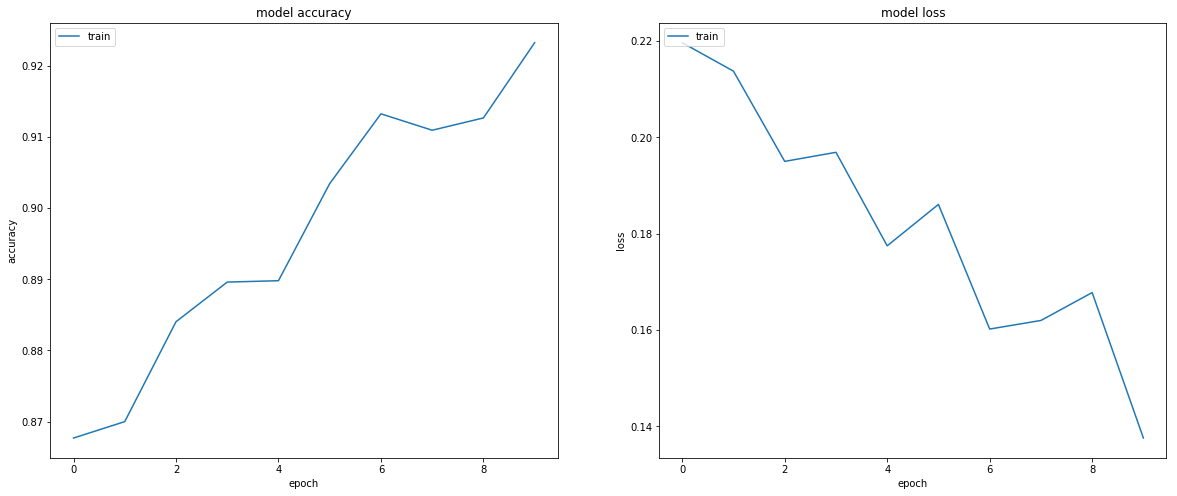

In [38]:
plot_learning_curve(history)
plt.show()

## Recall and Precision
When a particular problem includes an imbalanced dataset, then accuracy isn't a good metric to look for. For example, if your dataset contains 95 negatives and 5 positives, having a model with 95% accuracy doesn't make sense at all. The classifier might label every example as negative and still achieve 95% accuracy. Hence, we need to look for alternative metrics. Precision and Recall are really good metrics for such kind of problems.

In [37]:
cm  = confusion_matrix(orig_test_labels, preds)
cm

array([[124,  10, 100],
       [  3, 223,  16],
       [  1,  20, 127]], dtype=int64)

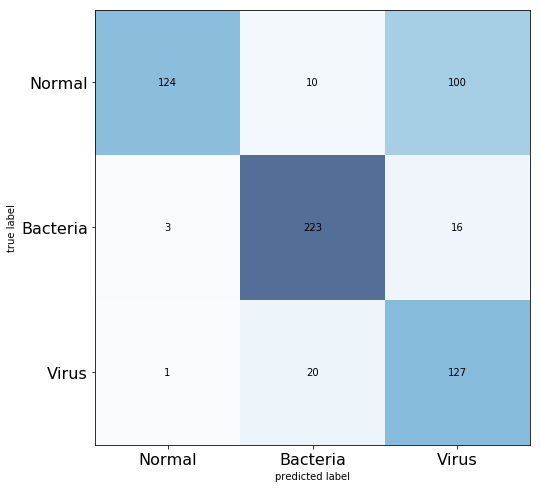

In [38]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, alpha=0.7,cmap=plt.cm.Blues)
plt.xticks(range(3), ['Normal', 'Bacteria', 'Virus'], fontsize=16)
plt.yticks(range(3), ['Normal', 'Bacteria', 'Virus'], fontsize=16)
plt.show()

In [39]:
cm[0][0]

124

In [40]:
tn = cm[0][0]
fn = cm[0][1]+cm[0][2]
tb = cm[1][1]
fb = cm[1][0]+cm[1][2]
tv = cm[2][2]
fv = cm[2][0]+cm[2][1]

In [41]:
# Calculate Precision and Recall
# tn, fb, fn, tb = cm.ravel()

recall = (tb+tv)/(tb+fb+tv+fv)
precision = (tb+tv)/(tb+tv+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.90
Precision of the model is 0.76


## The Conclusion

So, our model has a 90% recall. In such problems, a good recall value is expected. But if you notice, the precision is only 76%. This is one thing to notice. Precision and Recall follows a trade-off, and you need to find a point where your recall, as well as your precision, is more than good but both can't increase simultaneously.

## Data Source

We will use "Chest X-Ray Images (Pneumonia)" dataset from Kaggle.com
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/home

## References 

* Daniel S. Kermany , Michael Goldbaum , Wenjia Cai , Carolina C.S. Valentim , Huiying Liang , M. Anthony Lewis , Huimin Xia ,Kang Zhang<br>
  __Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning__ <br>
  _VOLUME 172, ISSUE 5, P1122-1131.E9, FEBRUARY 22, 2018_ <br>
  http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5 <br>

  
* Eli Bendersky's <br>
  __Depthwise separable convolutions for machine learning__ <br>
  _April 04, 2018 at 06:21_ <br>
  https://eli.thegreenplace.net/2018/depthwise-separable-convolutions-for-machine-learning/ <br>
  
  
* Krizhevsky, Alex, Ilya Sutskever, Geoffrey E. Hinton <br>
  __Imagenet classification with deep convolutional neural networks__ <br>
  Advances in neural information 	processing systems. 2012 <br>
  https://www.nvidia.cn/content/tesla/pdf/machine-learning/imagenet-classification-with-deep-convolutional-nn.pdf

## License

[![MIT](http://nikbearbrown.com/YouTube/MachineLearning/IMG/MIT-license-sm.png)](https://opensource.org/licenses/MIT)

The MIT License (MIT)
=====================

Permission is hereby granted, free of charge, to any person
obtaining a copy of this software and associated documentation
files (the “Software”), to deal in the Software without
restriction, including without limitation the rights to use,
copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following
conditions:

The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY,
WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR
OTHER DEALINGS IN THE SOFTWARE.